In [253]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor

# Read the data
X = pd.read_csv('../data/train.csv', index_col='Id')
X_test_full = pd.read_csv('../data/train.csv', index_col='Id')


In [254]:
# Add initial helper function for estimating accuracy
def get_score(pipeline, n_folds=3):
    """Return the average MAE over n_folds CV folds of XGBoost model.
    
    Keyword argument:
    pipeline == a sklearn pipeline
    n_folds == the number of CV folds
    """
    scores = -1 * cross_val_score(pipeline, X, y, cv=n_folds, scoring='neg_mean_absolute_error')
    return scores.mean()

In [255]:
X.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [256]:
X.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [257]:
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [258]:
# numerical 
X.dtypes[X.dtypes != 'object']

MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice          int64
dtype: object

# Data Exploration
Exploring the data using scatter plots to identify outliers. 

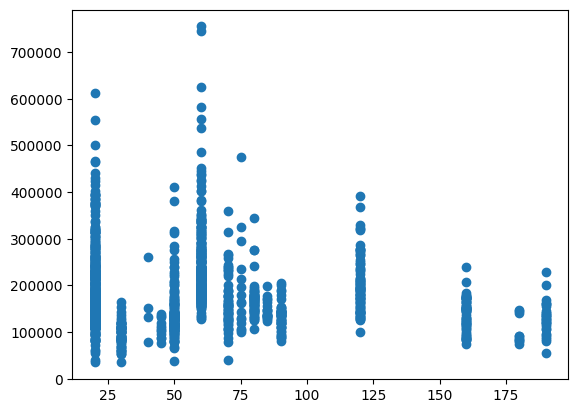

In [259]:
# This is more a categorical data point -- TODO handle this
plt.scatter(x='MSSubClass', y='SalePrice', data=X)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
935,20,RL,313.0,27650,Pave,NaN,IR2,HLS,AllPub,Inside,...,0,NaN,NaN,NaN,0,11,2008,WD,Normal,242000
1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


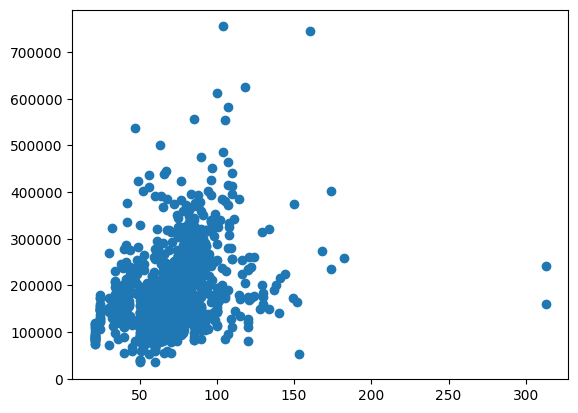

In [260]:
plt.scatter(x='LotFrontage', y='SalePrice', data=X)
X.query('LotFrontage > 300') # Outliers: 935, 1299

Id
385      4.268474
458      4.280500
770      4.308262
1397     4.678682
1299     5.348867
452      6.037793
707     10.486449
250     14.881285
336     15.448542
314     20.518273
Name: LotArea, dtype: float64

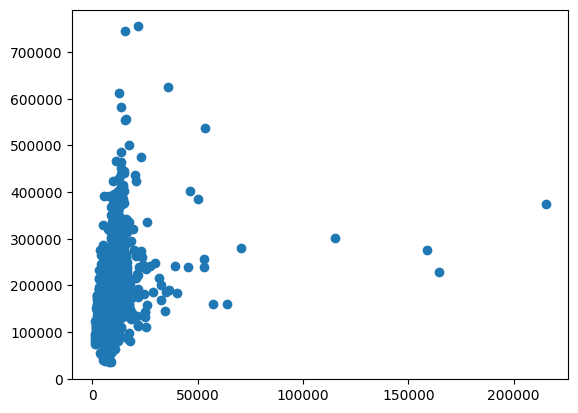

In [261]:
plt.scatter(x='LotArea', y='SalePrice', data=X)
X.query('LotArea > 100000')
stats.zscore(X['LotArea']).sort_values().tail(10)
# Outliers: 250, 314, 336, 707

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


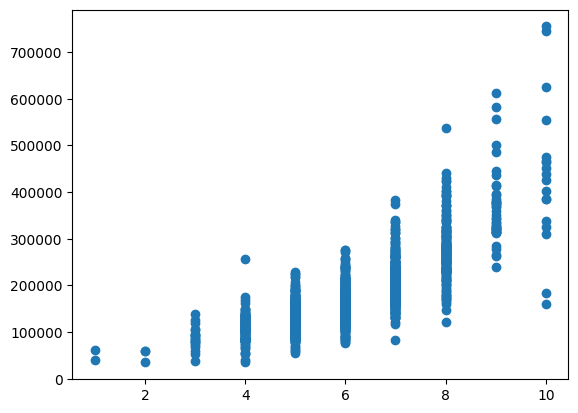

In [262]:
plt.scatter(x='OverallQual', y='SalePrice', data=X)
X.query('OverallQual == 10 and SalePrice < 200000') # Outliers: 524, 1299
# TODO should this and the following be handled the same as other numerical?

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
379,20,RL,88.0,11394,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,6,2010,New,Partial,394432


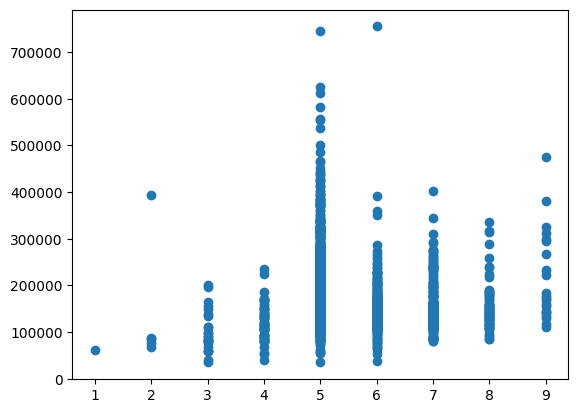

In [263]:
plt.scatter(x='OverallCond', y='SalePrice', data=X)
X.query('OverallCond == 2 and SalePrice > 375000') # Outlier: 379 
# Sale Price outliers: 692 (OverallCond == 6), 1183 (OverallCond == 5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
186,75,RM,90.0,22950,Pave,NaN,IR2,Lvl,AllPub,Inside,...,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,475000


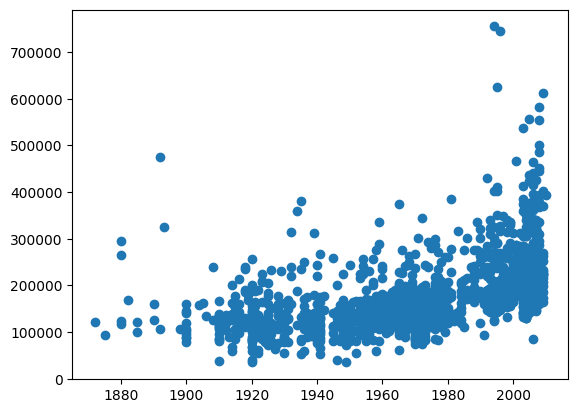

In [264]:
plt.scatter(x='YearBuilt', y='SalePrice', data=X)
X.query('YearBuilt < 1900 and SalePrice > 400000') # Outlier: 186

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
314,20,RL,150.0,215245,Pave,NaN,IR3,Low,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,375000


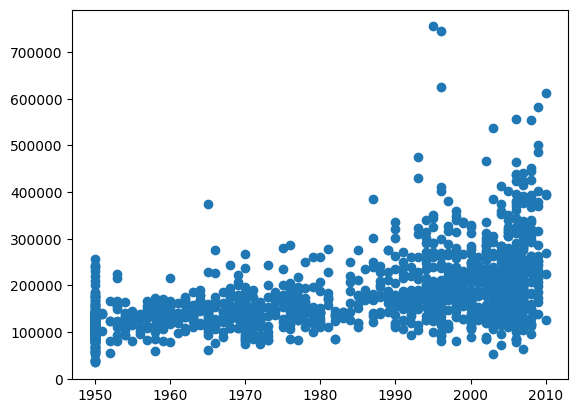

In [265]:
plt.scatter(x='YearRemodAdd', y='SalePrice', data=X)
X.query('YearRemodAdd < 1970 and SalePrice > 300000') # Outlier: 314
# stats.zscore(X['YearRemodAdd']).sort_values().tail(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
298,60,FV,66.0,7399,Pave,Pave,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,239000


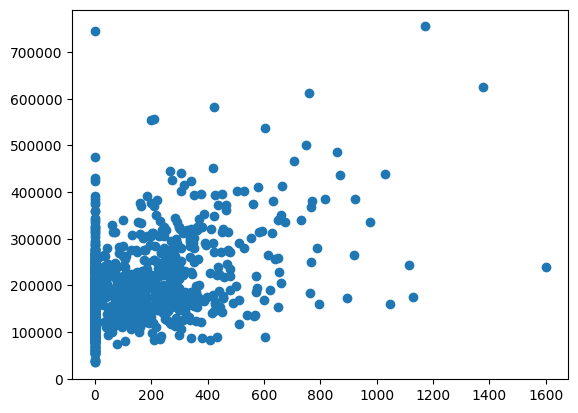

In [266]:
plt.scatter(x='MasVnrArea', y='SalePrice', data=X)
X.query('MasVnrArea > 1500') # Outlier: 298

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


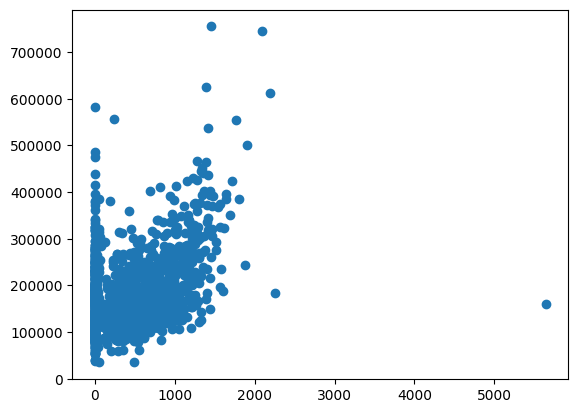

In [267]:
plt.scatter(x='BsmtFinSF1', y='SalePrice', data=X)
X.query('BsmtFinSF1 > 5000') # Outliers: 1299

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
441,20,RL,105.0,15431,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,555000


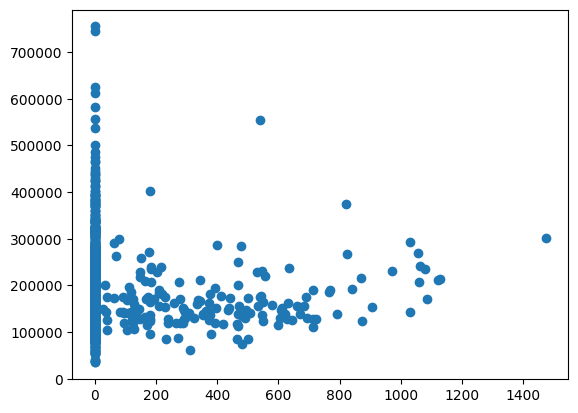

In [268]:
plt.scatter(x='BsmtFinSF2', y='SalePrice', data=X)
X.query('BsmtFinSF2 > 1400') # Outlier: 323 (this one might be ok)
X.query('BsmtFinSF2 > 400 and SalePrice > 500000') # Outlier: 441
# stats.zscore(X['BsmtFinSF2']).sort_values().tail(15) # there are a lot of high zscores here

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


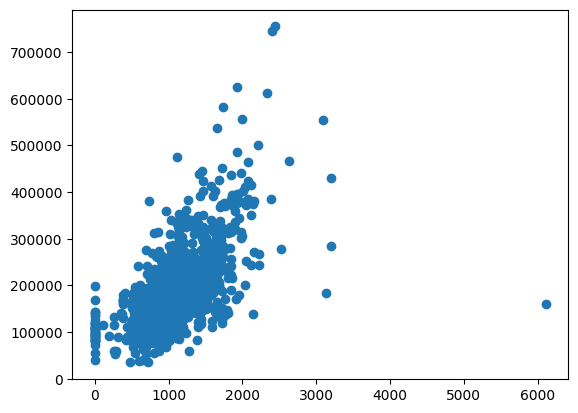

In [269]:
plt.scatter(x='TotalBsmtSF', y='SalePrice', data=X)
X.query('TotalBsmtSF > 6000') # Outlier: 1299

Id
844     2.790845
964     2.790845
769     2.872345
351     2.947054
933     3.028554
138     3.033082
799     3.076096
775     3.096471
497     3.173444
1268    3.248152
582     3.338708
679     3.347764
279     3.517556
478     3.590001
225     4.004295
Name: BsmtUnfSF, dtype: float64

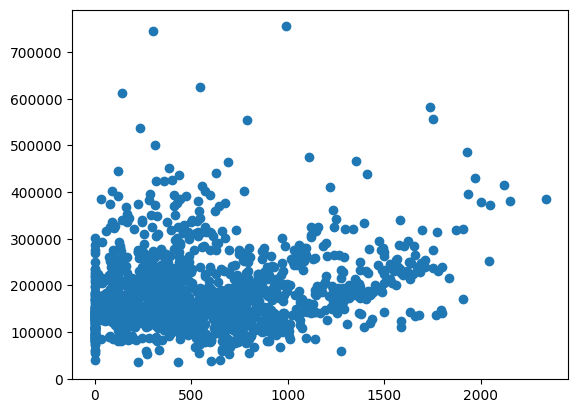

In [270]:
plt.scatter(x='BsmtUnfSF', y='SalePrice', data=X)
stats.zscore(X['BsmtUnfSF']).sort_values().tail(15)
# TODO not sure if any should be removed here, seems like maybe not a good indicator?

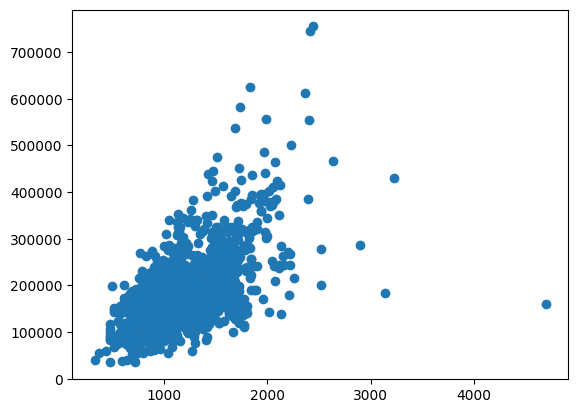

In [271]:
plt.scatter(x='1stFlrSF', y='SalePrice', data=X)

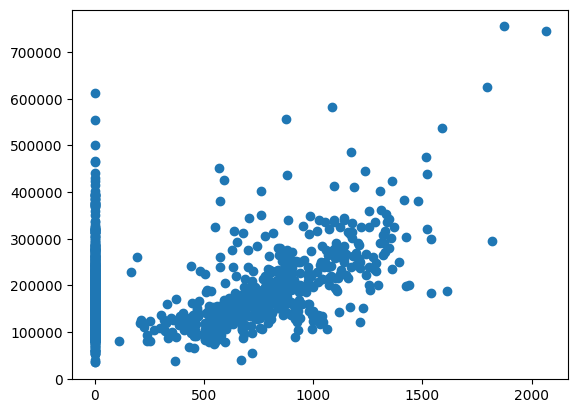

In [272]:
plt.scatter(x='2ndFlrSF', y='SalePrice', data=X)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
186,75,RM,90.0,22950,Pave,NaN,IR2,Lvl,AllPub,Inside,...,0,NaN,GdPrv,NaN,0,6,2006,WD,Normal,475000


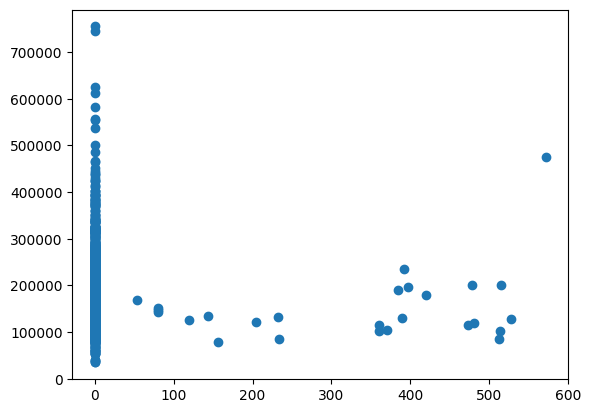

In [273]:
plt.scatter(x='LowQualFinSF', y='SalePrice', data=X)
X.query('LowQualFinSF > 550') # Outlier: 186

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


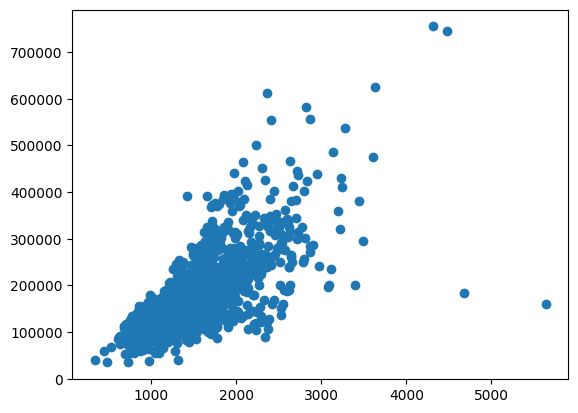

In [274]:
plt.scatter(x='GrLivArea', y='SalePrice', data=X)
X.query('GrLivArea > 4500 and SalePrice < 250000') # Outliers: 524, 1299

array([ 1.10781015, -0.81996437,  3.03558466,  4.96335918])

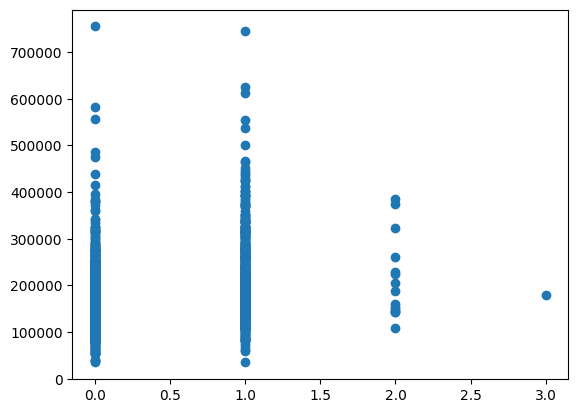

In [275]:
plt.scatter(x='BsmtFullBath', y='SalePrice', data=X)
X.query('BsmtFullBath == 3') # 739
stats.zscore(X['BsmtFullBath']).unique() # the 2.0 have a high zscore, unsure how to handle

array([-0.24106104,  3.94880935,  8.13867973])

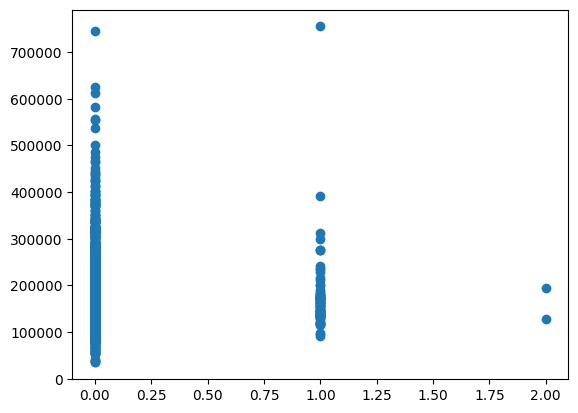

In [276]:
plt.scatter(x='BsmtHalfBath', y='SalePrice', data=X)
X.query('BsmtHalfBath == 2') # 598, 955 # High z score, should probably remove
stats.zscore(X['BsmtHalfBath']).unique()

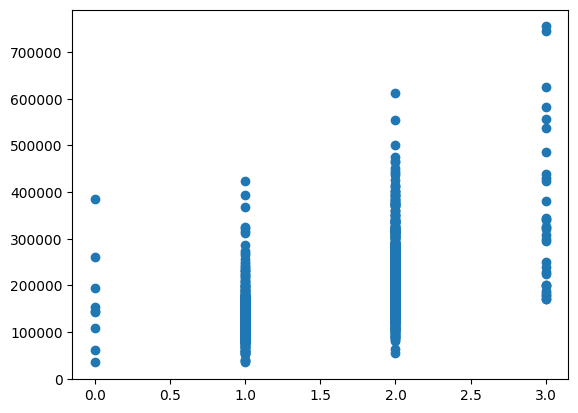

In [277]:
plt.scatter(x='FullBath', y='SalePrice', data=X)

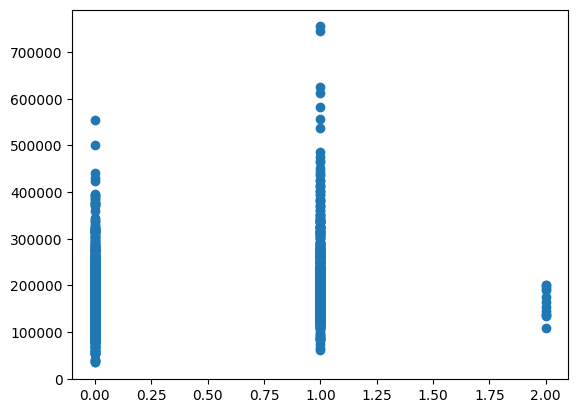

In [278]:
plt.scatter(x='HalfBath', y='SalePrice', data=X)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
636,190,RH,60.0,10896,Pave,Pave,Reg,Bnk,AllPub,Inside,...,0,NaN,NaN,NaN,0,3,2007,WD,Abnorml,200000


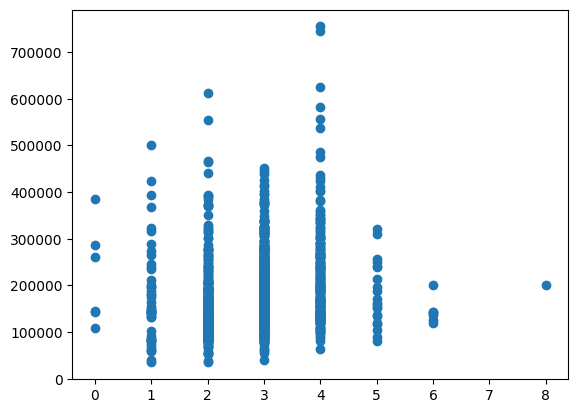

In [279]:
plt.scatter(x='BedroomAbvGr', y='SalePrice', data=X)
X.query('BedroomAbvGr == 8') # Outlier: 636

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
49,190,RM,33.0,4456,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2009,New,Partial,113000
810,75,RM,90.0,8100,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,MnPrv,NaN,0,11,2009,WD,Normal,106000


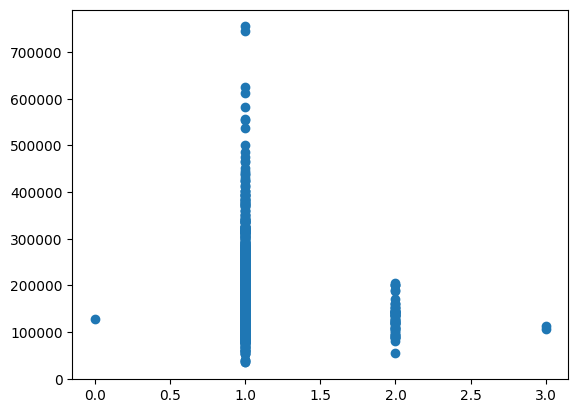

In [280]:
plt.scatter(x='KitchenAbvGr', y='SalePrice', data=X)
X.query('KitchenAbvGr == 3') # Outliers: 49, 810

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
636,190,RH,60.0,10896,Pave,Pave,Reg,Bnk,AllPub,Inside,...,0,NaN,NaN,NaN,0,3,2007,WD,Abnorml,200000


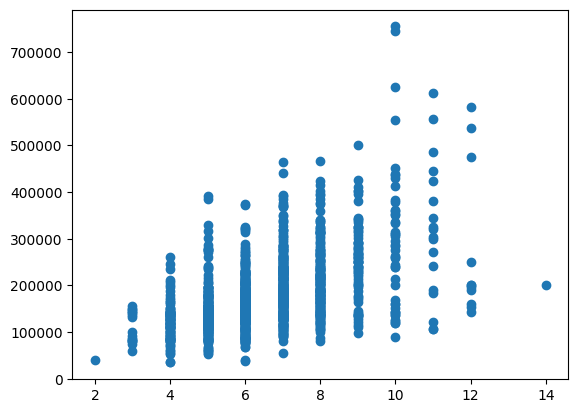

In [281]:
plt.scatter(x='TotRmsAbvGrd', y='SalePrice', data=X)
X.query('TotRmsAbvGrd == 14') # Outlier: 636

array([-0.95122649,  0.60049493,  2.15221636,  3.70393778])

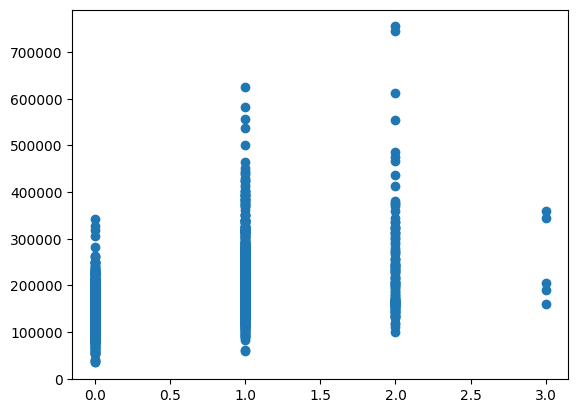

In [282]:
plt.scatter(x='Fireplaces', y='SalePrice', data=X)
stats.zscore(X['Fireplaces']).unique() # 3 Fireplaces: 3.7
# 3 Fireplaces: 167, 310, 606, 643, 1299 - not sure if these should be removed

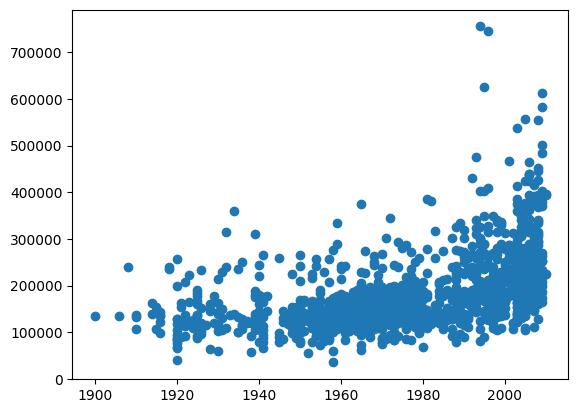

In [283]:
plt.scatter(x='GarageYrBlt', y='SalePrice', data=X)

array([ 0.31172464,  1.65030694, -1.02685765, -2.36543995,  2.98888924])

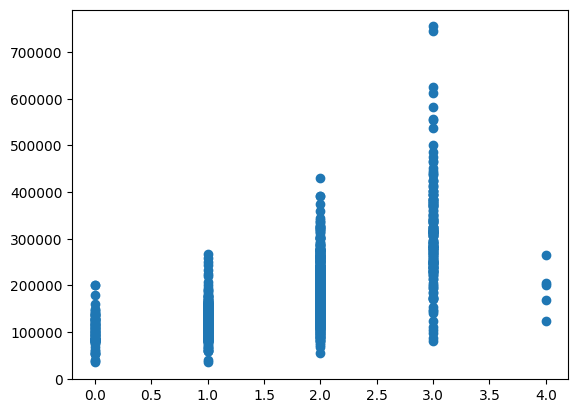

In [284]:
plt.scatter(x='GarageCars', y='SalePrice', data=X)
X.query('GarageCars == 4') # 421, 748, 1191, 1341, 1351 - think this is ok to leave in
stats.zscore(X['GarageCars']).unique()

Id
1229    2.709098
271     2.713777
1418    2.788637
665     3.092757
179     3.242477
826     3.495131
1062    3.626136
1191    4.131443
582     4.290521
1299    4.421526
Name: GarageArea, dtype: float64

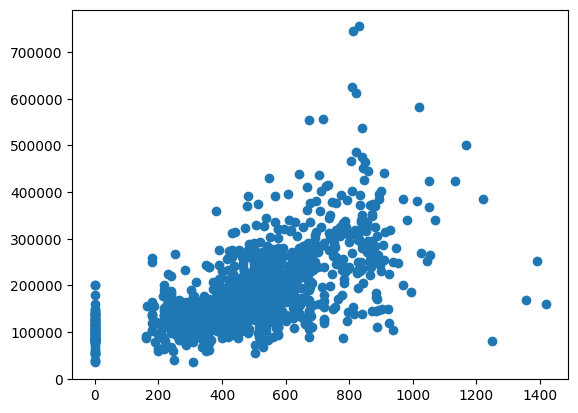

In [285]:
plt.scatter(x='GarageArea', y='SalePrice', data=X)
stats.zscore(X['GarageArea']).sort_values().tail(10)
# High Z Score: 1299, 582, 1191, maybe 1062, 826

In [286]:
X['GarageCars'].corr(X['GarageArea'])

0.8824754142814625

In [287]:
X['GarageCars'].corr(X['SalePrice'])

0.6404091972583529

In [288]:
X['GarageArea'].corr(X['SalePrice'])

0.6234314389183618

Id
962     3.637434
170     3.828981
65      3.844943
1424    3.924754
1211    4.315829
1314    4.579205
336     4.595168
1069    5.058072
1460    5.121921
54      6.087635
Name: WoodDeckSF, dtype: float64

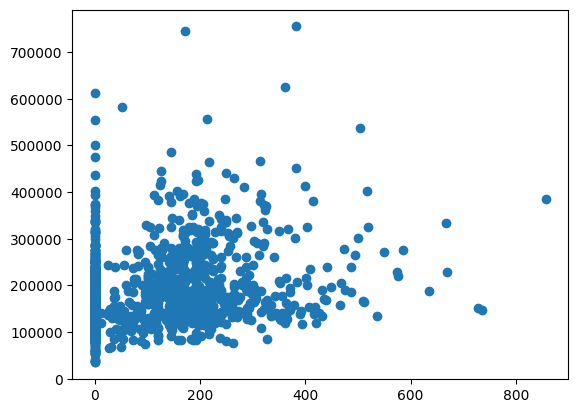

In [289]:
plt.scatter(x='WoodDeckSF', y='SalePrice', data=X)
stats.zscore(X['WoodDeckSF']).sort_values().tail(10)
# High score (look into these): 54, 1460, 1069, 336

Id
808     4.006136
646     4.006136
997     4.111823
736     4.443982
876     4.791239
524     5.425361
855     5.606538
584     6.874782
496     7.191843
1329    7.554198
Name: OpenPorchSF, dtype: float64

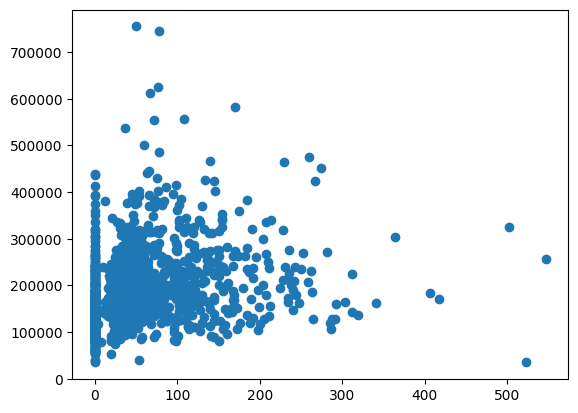

In [290]:
plt.scatter(x='OpenPorchSF', y='SalePrice', data=X)
stats.zscore(X['OpenPorchSF']).sort_values().tail(10)
# X.query('OpenPorchSF > 325') # Outliers: 496, 524, 584, 855, 1329, 736, 876
# Note: the tutorial only removed 496 here

Id
1153    4.223460
1327    4.321663
497     4.403498
631     4.436233
359     4.452600
1361    4.567169
940     4.845410
1198    5.041815
748     5.958372
198     8.675309
Name: EnclosedPorch, dtype: float64

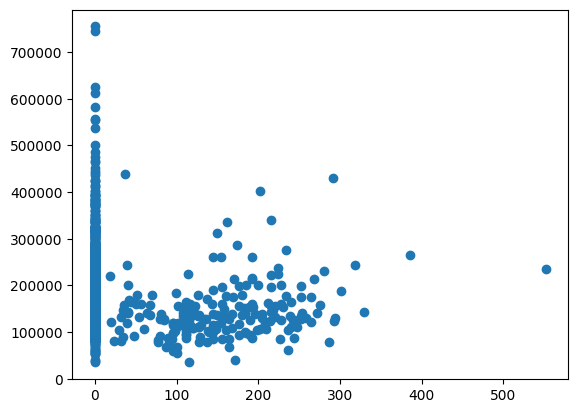

In [291]:
plt.scatter(x='EnclosedPorch', y='SalePrice', data=X)
stats.zscore(X['EnclosedPorch']).sort_values().tail(10)
# X.query('EnclosedPorch > 350') # Outliers: 198, 748
# Note: the tutorial only removes 198 here but there are some other high zscores

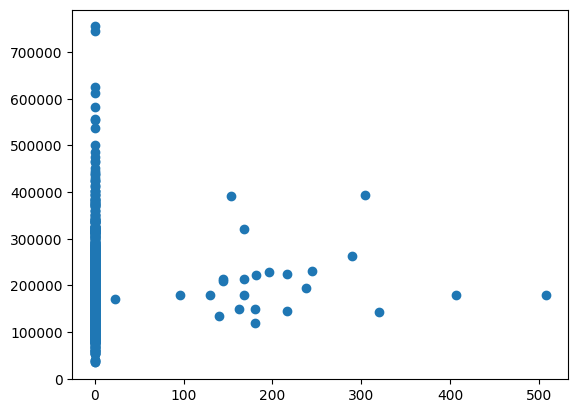

In [292]:
plt.scatter(x='3SsnPorch', y='SalePrice', data=X)
# TODO we could maybe chance this to has vs doesn't have

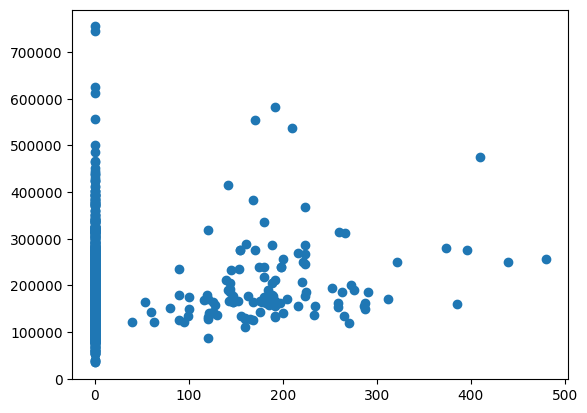

In [293]:
plt.scatter(x='ScreenPorch', y='SalePrice', data=X)

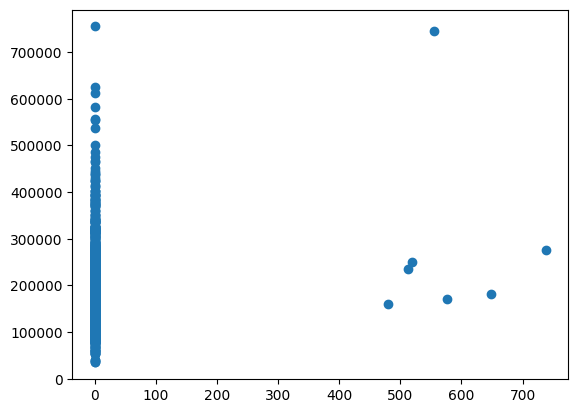

In [294]:
plt.scatter(x='PoolArea', y='SalePrice', data=X)

In [295]:
# TODO: skipping misc features

After we've looked at all of our numerical values, we'll decide which ones to remove. I have two lists for now -- "values" with likely outliers, and "undecided" with values that I'm undecided if they should be removed. 

In [296]:
values =  [49, 186, 198, 250, 298, 314, 336, 379, 441, 496, 524, 582, 598, 636, 707, 739, 810, 935, 955, 1191, 1299, 1329]
print(len(values)) # => 22
undecided = [54, 323, 584, 748, 826, 855, 1062, 1069, 1460]

# Remove rows with missing target
X.dropna(axis=0, subset=['SalePrice'], inplace=True)

# Remove rows with outliers 
X.drop(values)

22


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


Next we need to handle missing values

In [297]:
pd.DataFrame(X.isnull().sum().sort_values(ascending=False)).head(20)
# Ignoring MiscFeature (could look into this to think of some way to represent these)

,0
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
MasVnrType,872
FireplaceQu,690
LotFrontage,259
GarageYrBlt,81
GarageCond,81
GarageType,81


In [298]:
def replace_empty_value(col, value):
    """Replaces empty in train and test set in the provided column 
    name with the provided value
    
    col = the column name
    value = the replacement value
    """
    global X, X_test_full
    X[col].fillna(value, inplace=True)
    X_test_full[col].fillna(value, inplace=True)

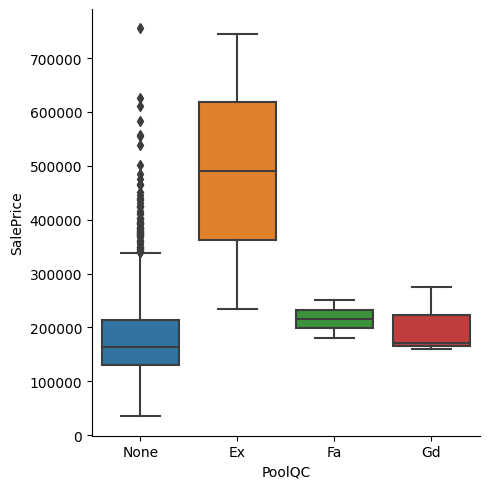

In [299]:
replace_empty_value('PoolQC', 'None')
sns.catplot(data=X, x='PoolQC', y='SalePrice', kind='box')

In [300]:
X['Alley'].unique()

array([nan, 'Grvl', 'Pave'], dtype=object)

In [301]:
replace_empty_value('Alley', 'None')

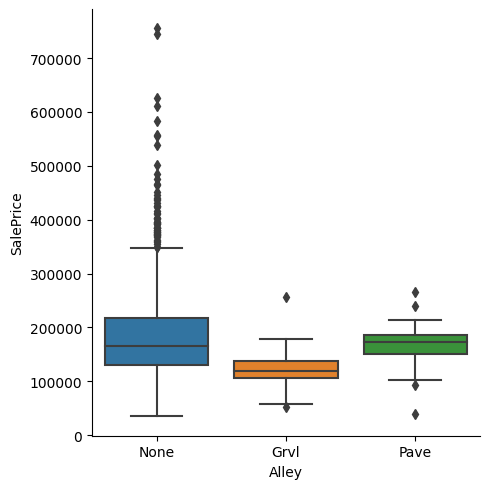

In [302]:
sns.catplot(data=X, x='Alley', y='SalePrice', kind='box')

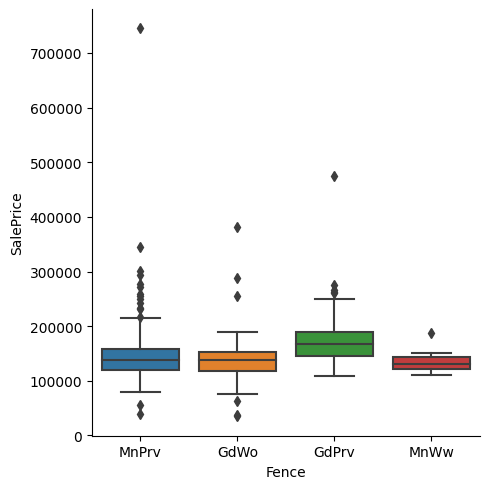

In [303]:
X['Fence'].unique()
sns.catplot(data=X, x='Fence', y='SalePrice', kind='box')
replace_empty_value('Fence', 'None')

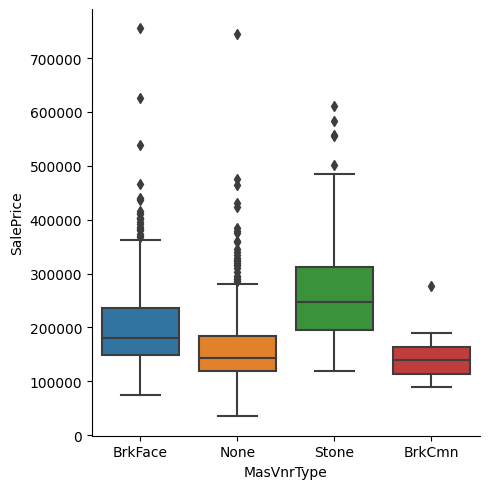

In [304]:
replace_empty_value('MasVnrType', 'None')
replace_empty_value('MasVnrArea', 0)
sns.catplot(data=X, x='MasVnrType', y='SalePrice', kind='box')

In [305]:
X['FireplaceQu'].unique()
replace_empty_value('FireplaceQu', 'None')

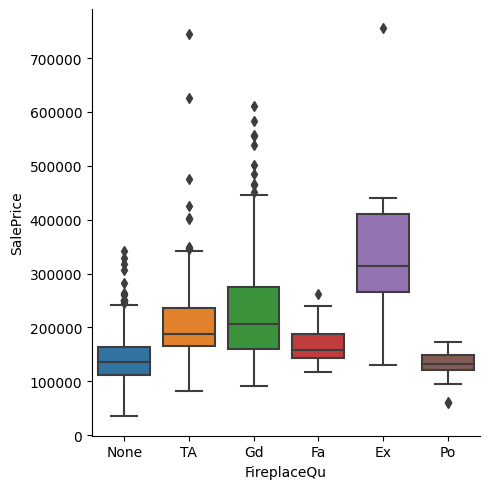

In [306]:
sns.catplot(data=X, x='FireplaceQu', y='SalePrice', kind='box')

In [307]:
replace_empty_value('LotFrontage', 0)

In [308]:
X['GarageYrBlt'].corr(X['YearBuilt']) # Will drop GarageYrBlt due to strong correlation
# Probably will drop some of these other Garage ones too

0.8256674841743421

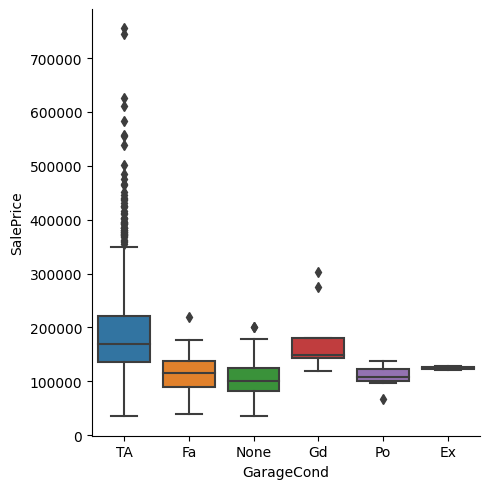

In [309]:
X['GarageCond'].unique()
replace_empty_value('GarageCond', 'None')
sns.catplot(data=X, x='GarageCond', y='SalePrice', kind='box')

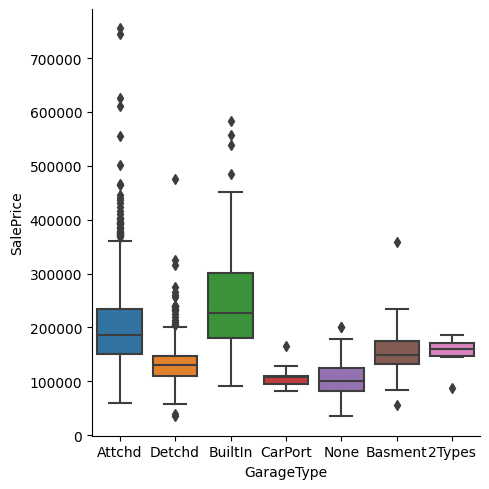

In [310]:
X['GarageType'].unique()
replace_empty_value('GarageType', 'None')
sns.catplot(data=X, x='GarageType', y='SalePrice', kind='box')

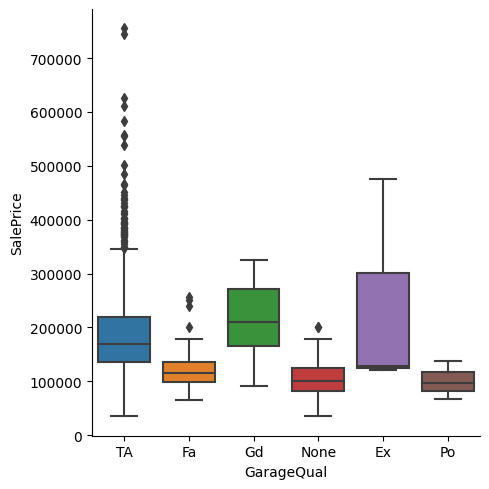

In [311]:
X['GarageQual'].unique()
replace_empty_value('GarageQual', 'None')
sns.catplot(data=X, x='GarageQual', y='SalePrice', kind='box')

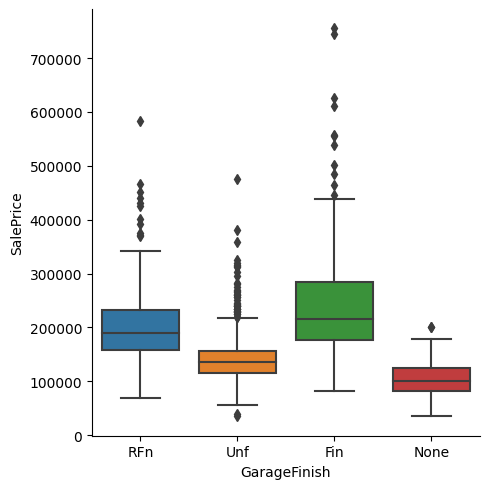

In [312]:
X['GarageFinish'].unique()
replace_empty_value('GarageFinish', 'None')
sns.catplot(data=X, x='GarageFinish', y='SalePrice', kind='box')

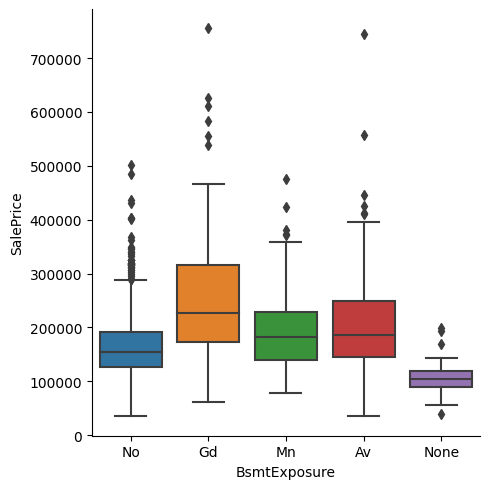

In [313]:
X['BsmtExposure'].unique()
replace_empty_value('BsmtExposure', 'None')
sns.catplot(data=X, x='BsmtExposure', y='SalePrice', kind='box')

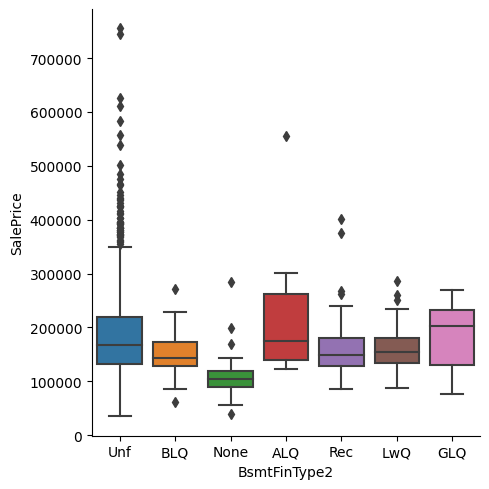

In [314]:
replace_empty_value('BsmtFinType2', 'None')
sns.catplot(data=X, x='BsmtFinType2', y='SalePrice', kind='box')

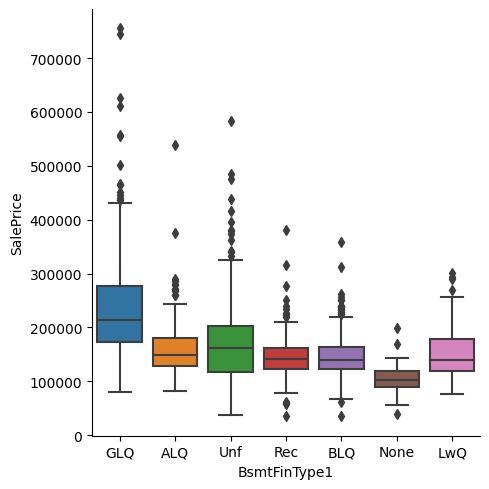

In [315]:
replace_empty_value('BsmtFinType1', 'None')
sns.catplot(data=X, x='BsmtFinType1', y='SalePrice', kind='box')

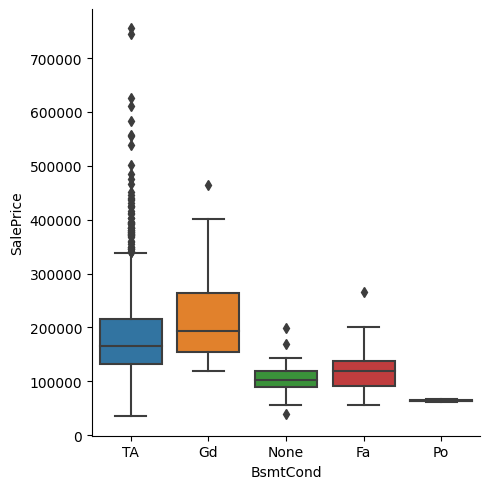

In [316]:
replace_empty_value('BsmtCond', 'None')
sns.catplot(data=X, x='BsmtCond', y='SalePrice', kind='box')

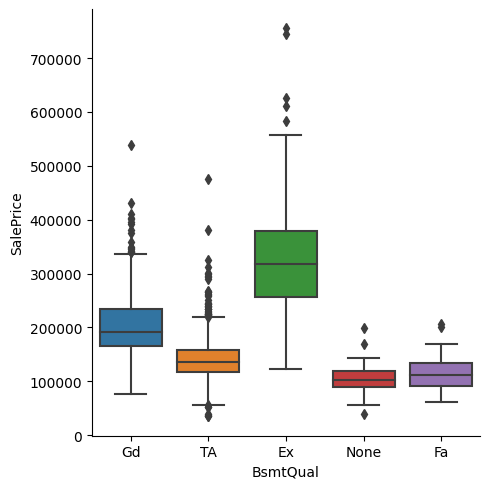

In [317]:
replace_empty_value('BsmtQual', 'None')
sns.catplot(data=X, x='BsmtQual', y='SalePrice', kind='box')

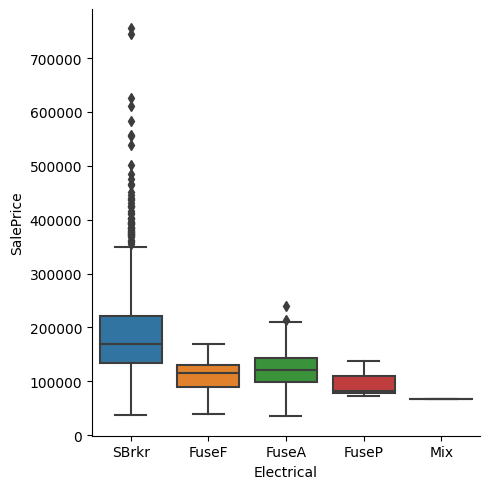

In [318]:
X['Electrical'].unique()
X.query('Electrical.isna()') # 1380 
sns.catplot(data=X, x='Electrical', y='SalePrice', kind='box')

In [319]:
X['Electrical'].value_counts()

Electrical
SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: count, dtype: int64

In [320]:
X.loc[1380, 'YearBuilt'] # 2006
# Filling the missing value with SBrkr because all homes built after the 70s seem to have it
# After some research, it looks like it was phased in starting in the 60s
electrical_fill_cond = (pd.to_numeric(X['YearBuilt'], errors='coerce') > 1970) & (X['Electrical'].isna())
X.loc[electrical_fill_cond, 'Electrical'] = 'SBrkr'

electrical_fill_cond = (pd.to_numeric(X_test_full['YearBuilt'], errors='coerce') > 1970) & (X_test_full['Electrical'].isna())
X_test_full.loc[electrical_fill_cond, 'Electrical'] = 'SBrkr'

Next we need to decide what columns to drop.

The tutorial drops Pool, but I want to keep it for now -- maybe we have Pool vs No Pool, although the quality does seem to matter.

The tutorial says definitely want to drop MiscFeature, Alley, Fence (due to amount missing)

Dropping GarageYrBlt due to correlation.

Dropping GarageCond because it looks a lot like GarageQual, but might want to revisit and make these ordinal and check out more. (tutorial drops but doesn't say why)

Tutorial doesn't do this but I'm going to drop GarageArea because it has a high correlation with GarageCars and cars seems to have a higher correlation with SalePrice.

BsmtFinType1 and BsmtFinType2 are interesting because the only thing that really seems to score higher is having GLQ as type 1 (Good Living Quarters). It's also interesting that ALQ as type 2 is highest. This is probably because having GLQ as type 2 has a smaller sqft of good living quarters. It makes me think the important thing is the amount of GLQ. Not sure if I know how to model/test that at this moment. The other related fields are BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, and TotalBsmtSF

Tutorial keeps BsmtCond and BsmtQual even tho they don't keep GarageQual and GarageCond -- not sure how that makes sense, need to look into correlation more.

In [321]:
def drop_features(features_to_drop):
    """
    Drops features (columns) from training and testing data.
    
    features_to_drop = an array of column names
    """
    global X, X_test_full
    X = X.drop(columns=features_to_drop)
    X_test_full = X_test_full.drop(columns=features_to_drop)

In [322]:
drop_features(['MiscFeature', 'Alley', 'Fence', 'GarageArea', 'GarageYrBlt', 'GarageCond'])

Next feature engineering (alongside tutorial)

In [323]:
def add_feature(feature_name, feature_fn):
    """
    Add a new feature to the training and test data
    
    feature_name = the name of the feature
    feature_fn = the function that returns the value, parameter is the dataframe
    
    ex:
    add_feature('HouseAge', lambda df: df['YearSold'] - df['YearBuilt'])
    """
    X[feature_name] = feature_fn(X)
    X_test_full[feature_name] = feature_fn(X_test_full)

In [324]:
add_feature('HouseAge', lambda df: df['YrSold'] - df['YearBuilt'])

In [325]:
add_feature('HouseRemodelAge', lambda df: df['YrSold'] - df['YearRemodAdd'])

In [326]:

add_feature('TotalSF', lambda df: df['1stFlrSF'] + df['2ndFlrSF'] + df['BsmtFinSF1'] + df['BsmtFinSF2'])

In [327]:
add_feature('TotalArea', lambda df: df['GrLivArea'] + df['TotalBsmtSF'])

In [328]:
add_feature('TotalBaths', lambda df: df['FullBath'] + df['BsmtFullBath'] + (.5 * df['BsmtHalfBath']) + (.5 * df['HalfBath']))

In [329]:
add_feature('TotalPorchSF', lambda df: df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + df['ScreenPorch'] + df['WoodDeckSF'])

In [330]:
drop_features(['MoSold', 'YrSold', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtFinSF2', 'GrLivArea', 'TotalBsmtSF', 'BsmtFullBath', 'FullBath', 'BsmtHalfBath', 'HalfBath', 'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch', 'WoodDeckSF'])

In [331]:
# X.drop(columns=['Id'])
drop_features(['SaleType', 'SaleCondition'])
# TODO look into this more -- but I'm afraid keeping it will cause leaky data? I think is the term

<Axes: >

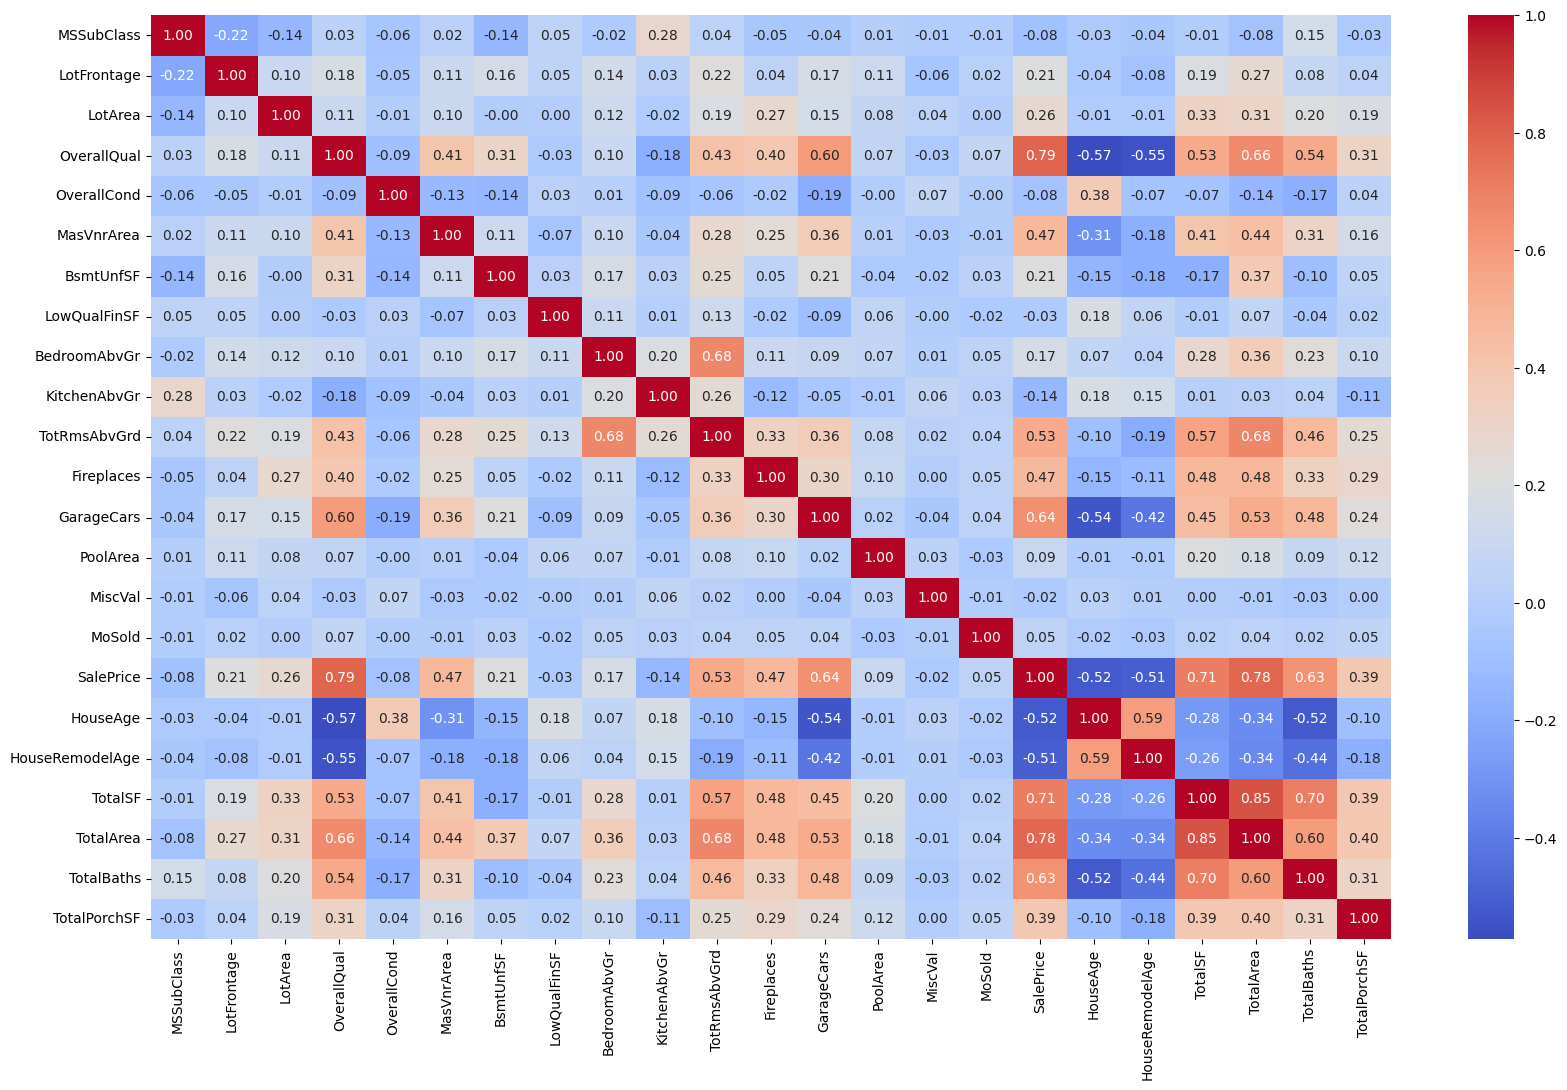

In [332]:
correlation_matrix = X.corr(numeric_only=True)
plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

TotRmsAbvGrd has somewhat high correlation with BedroomAbvGr and TotalArea


<Axes: xlabel='SalePrice', ylabel='Count'>

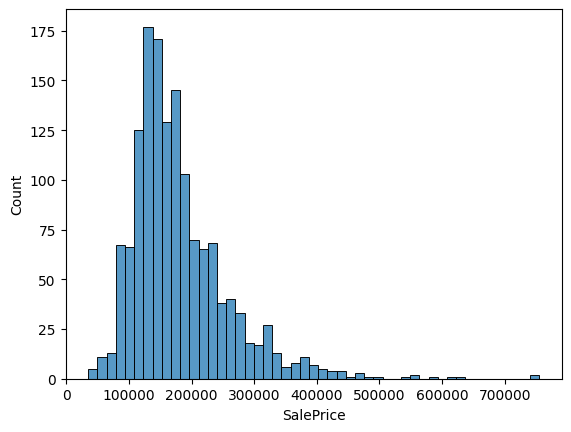

In [333]:
sns.histplot(X, x=X['SalePrice'])

In [334]:
X['SalePrice'] = np.log1p(X['SalePrice'])
# TODO look at other options here and try to understand why it's needed

<Axes: xlabel='SalePrice', ylabel='Count'>

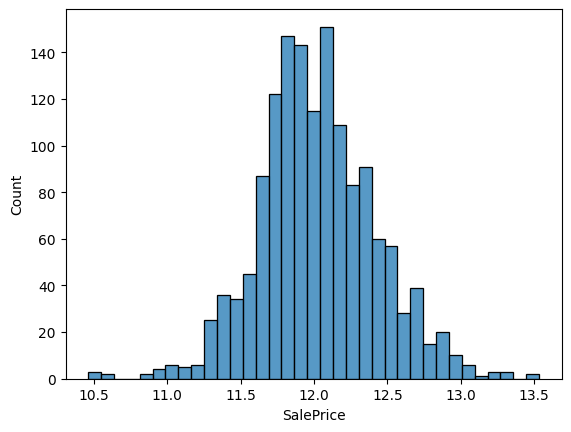

In [335]:
sns.histplot(X, x=X['SalePrice'])

In [336]:
X.dtypes[X.dtypes =='object']

MSZoning        object
Street          object
LotShape        object
LandContour     object
Utilities       object
LotConfig       object
LandSlope       object
Neighborhood    object
Condition1      object
Condition2      object
BldgType        object
HouseStyle      object
RoofStyle       object
RoofMatl        object
Exterior1st     object
Exterior2nd     object
MasVnrType      object
ExterQual       object
ExterCond       object
Foundation      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Heating         object
HeatingQC       object
CentralAir      object
Electrical      object
KitchenQual     object
Functional      object
FireplaceQu     object
GarageType      object
GarageFinish    object
GarageQual      object
PavedDrive      object
PoolQC          object
dtype: object

In [337]:
X.dtypes[X.dtypes !='object']

MSSubClass           int64
LotFrontage        float64
LotArea              int64
OverallQual          int64
OverallCond          int64
MasVnrArea         float64
BsmtUnfSF            int64
LowQualFinSF         int64
BedroomAbvGr         int64
KitchenAbvGr         int64
TotRmsAbvGrd         int64
Fireplaces           int64
GarageCars           int64
PoolArea             int64
MiscVal              int64
MoSold               int64
SalePrice          float64
HouseAge             int64
HouseRemodelAge      int64
TotalSF              int64
TotalArea            int64
TotalBaths         float64
TotalPorchSF         int64
dtype: object

In [338]:
# Ordinal 
ode_cols = ['LotShape', 'LandContour', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'PavedDrive', 'PoolQC']

In [339]:
# One hot encoding
ohe_cols = ['MSZoning', 'Street', 'Utilities', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
           'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'GarageType']

In [367]:
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
num_cols = num_cols.drop('SalePrice')

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'MasVnrArea', 'BsmtUnfSF', 'LowQualFinSF', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'PoolArea',
       'MiscVal', 'MoSold', 'HouseAge', 'HouseRemodelAge', 'TotalSF',
       'TotalArea', 'TotalBaths', 'TotalPorchSF'],
      dtype='object')

Need to go through each of these, and decide if it should be ordinal or one hot encoded. 

I'm wondering if SaleType and SaleCondition wouldn't be leaky data? Like would this be available? I kind of doubt it.

Wondering if I should change PoolQC to has pool vs doesn't but not sure yet.

In [341]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
])

In [342]:
ode_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

In [343]:
ohe_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [344]:
col_transformer = ColumnTransformer(transformers=[
    ('num_pipe', num_pipeline, num_cols),
    ('ode_pipe', ode_pipeline, ode_cols),
    ('ohe_pipe', ohe_pipeline, ohe_cols)
],
remainder='passthrough',
n_jobs=-1)

In [345]:
# Separate target from predictors
y = X.SalePrice
X.drop(['SalePrice'], axis=1, inplace=True)

Next we build models

In [346]:
lr_pipeline = Pipeline(steps=[
    ('preprocessing', col_transformer),
    ('lr_model', LinearRegression())
])

scoring_metrics = make_scorer(mean_squared_error, greater_is_better=False)

scores = -cross_val_score(lr_pipeline, X, y, cv=3, scoring=scoring_metrics)
scores.mean()

2.876194514704666e+19

In [347]:
mae = -cross_val_score(lr_pipeline, X, y, cv=3, scoring='neg_mean_absolute_error')
mae.mean()

410255174.52971286

In [348]:
X_preprocessed = Pipeline(steps=[('preprocessing', col_transformer)]).fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=25)
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [349]:
y_pred_lr = lr.predict(X_test)

In [350]:
mean_squared_error(y_test, y_pred_lr)

2.789422505040874e+16

In [351]:
rfr_model = RandomForestRegressor(random_state=13)

In [352]:
param_grid_rfr = {
    'max_depth': [5, 10, 15],
    'n_estimators': [100, 250, 500],
    'min_samples_split': [3, 5, 10]
}

In [353]:
rfr_cv = GridSearchCV(rfr_model, param_grid_rfr, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

In [354]:
rfr_pipeline = Pipeline(steps=[
    ('preprocessing', col_transformer),
    ('rfr_model', rfr_model)
])

In [355]:
scores = -cross_val_score(rfr_pipeline, X, y, cv=3, scoring=scoring_metrics)
scores.mean()

0.02063278967654228

In [356]:
param_grid_xgb = {
    'xgb_model__learning_rate': [.05, .1, .2],
    'xgb_model__n_estimators': [100, 200, 300],
    'xgb_model__max_depth': [2, 3, 4],
    'xgb_model__min_child_weight': [1, 2, 3],
    'xgb_model__gamma': [0, .1, .2],
    'xgb_model__subsample': [.8, .9, 1.0],
    'xgb_model__colsample_bytree': [.8, .9, 1.0]
}

In [357]:
xgb_pipeline = Pipeline(steps=[
    ('preprocessing', col_transformer),
    ('xgb_model', XGBRegressor(random_state=13))
])

In [358]:

xgb_cv = GridSearchCV(xgb_pipeline, param_grid_xgb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

In [359]:
scores = -cross_val_score(xgb_pipeline, X, y, cv=3, scoring=scoring_metrics)
scores.mean()

0.020452392698591112

In [360]:
scores = -cross_val_score(xgb_pipeline, X, y, cv=3, scoring='neg_mean_absolute_error')
scores.mean()

0.0965216049210758

In [361]:
xgb_cv.fit(X, y)
best_xgb_model = xgb_cv.best_estimator_

In [362]:
from joblib import dump

dump(best_xgb_model, '../models/house-price.joblib')

['../models/house-price.joblib']

In [363]:
feature_importances = best_xgb_model.named_steps['xgb_model'].feature_importances_
transformed_features = best_xgb_model.named_steps['preprocessing'].get_feature_names_out()
importances = pd.Series(feature_importances, index=transformed_features)
print(importances.sort_values(ascending=False))

num_pipe__OverallQual            0.225654
num_pipe__TotalArea              0.112656
ohe_pipe__CentralAir_N           0.051954
ohe_pipe__GarageType_None        0.050557
num_pipe__TotalSF                0.034680
                                   ...   
ohe_pipe__Condition1_PosA        0.000000
ohe_pipe__Exterior1st_BrkComm    0.000000
ohe_pipe__Exterior1st_AsphShn    0.000000
ohe_pipe__RoofMatl_WdShake       0.000000
ohe_pipe__Condition2_PosN        0.000000
Length: 184, dtype: float32


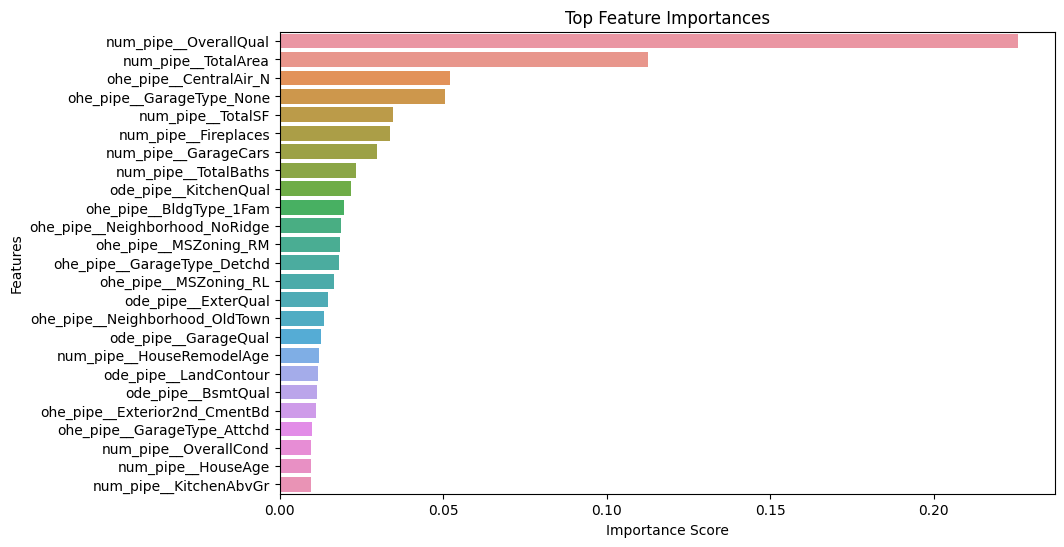

In [364]:
# Number of features to visualize
top_n = 25  

# Sort importances
sorted_importances = importances.sort_values(ascending=False)

# Plot top n feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_importances[:top_n], y=sorted_importances.index[:top_n])
plt.title('Top Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

In [365]:
len(X.columns)

59